In [1]:
import re, sys
import pandas as pd
import numpy as np
import json
from rdkit import Chem, DataStructs, RDLogger
from rdkit.Chem import rdChemReactions, AllChem, Draw, PandasTools
RDLogger.DisableLog('rdApp.*')
import warnings
warnings.filterwarnings('ignore')

In [2]:
def remove_bb_smi_label(smi):
    return re.sub(r"\[\d{2}\*\]", "[*]", smi)

#### Extract

In [3]:
with open("../data/raw/DORA_Lactam_mols_bbs.json", "r") as f:
    mols = json.load(f)
with open("../data/raw/DORA_Lactam_bbs.json", "r") as f:
    bbs = json.load(f)
    
df_mols = pd.json_normalize(mols)
df_bbs = pd.json_normalize(bbs)

#### Transform

In [4]:
df_bbs = df_bbs[["bb_smi", "bb_id"]]
df_mols = df_mols[["mol_smi", "mol_id", "A_id", "B_id", "C_id"]]

for col in ["A", "B", "C"]:
    df_mols = df_mols.merge(
        df_bbs,
        left_on=f"{col}_id",
        right_on="bb_id",
        how="left"
    ).rename(columns={"bb_smi": f"{col}_smi"}).drop(columns=["bb_id"])

df_mols = df_mols.dropna(subset=["A_id", "B_id", "C_id"])

In [5]:
for col in ["A_smi", "B_smi", "C_smi"]:
    df_mols[col] = df_mols[col].apply(remove_bb_smi_label)
    
df_mols['bbs_smi'] = df_mols['A_smi'] + '.' + df_mols['B_smi'] + '.' + df_mols['C_smi']

#### Save

In [6]:
df_mols.to_pickle("../data/transformed/df_mols_ready.pkl")

#### Augment

In [31]:
import pandas as pd
from rdkit import Chem
import random

def augment_smiles(smiles, num_aug=10):
    """
    Generate augmented SMILES strings for the same molecule.
    
    Args:
        smiles (str): input SMILES
        num_aug (int): number of augmented SMILES to generate
    
    Returns:
        list of str: augmented SMILES (non-canonical)
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return []
    
    aug_smiles = set()
    for _ in range(num_aug):
        # Use random atom ordering to generate non-canonical SMILES
        aug = Chem.MolToSmiles(mol, doRandom=True)
        aug_smiles.add(aug)
    
    return list(aug_smiles)
    
def augment_dataset(df, smiles_cols, n_aug=10):
    """
    Augment a dataset by randomizing SMILES in selected columns.
    
    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe.
    smiles_cols : list of str
        Column names that contain SMILES to augment.
    n_aug : int
        Number of augmented versions per row (excluding original).
    
    Returns
    -------
    pd.DataFrame
        Augmented dataframe with (n_aug+1) rows per original row.
    """
    augmented_rows = []
    
    for _, row in df.iterrows():
        # keep the original row
        augmented_rows.append(row.to_dict())
        
        # generate augmented rows
        for i in range(n_aug):
            new_row = row.to_dict()
            for col in smiles_cols:
                smi = row[col]
                aug_list = augment_smiles(smi, num_aug=10)
                new_row[col] = aug_list[0]
            augmented_rows.append(new_row)
    
    return pd.DataFrame(augmented_rows)

In [ ]:
aug_df = augment_dataset(df_mols, smiles_cols=["mol_smi", "A_smi", "B_smi", "C_smi"], n_aug=20)

In [22]:
aug_df.shape()

In [ ]:
smi = "CCOc1ccc2nc(S(N)(=O)=O)sc2c1"
print("Original:", smi)
print("Augmented:", augment_smiles(smi, num_aug=50))

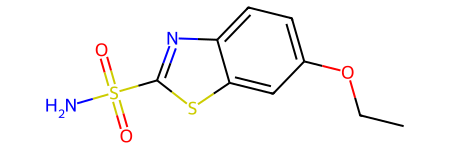

In [9]:
Chem.MolFromSmiles('c1c2c(nc(S(N)(=O)=O)s2)ccc1OCC')

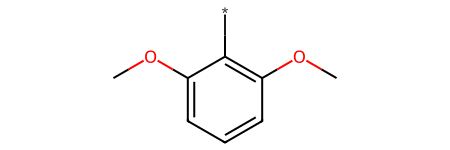

In [28]:
Chem.MolFromSmiles('c1ccc(c(c1OC)*)OC')